In [42]:
install.packages("glmnet")
install.packages("caret")
install.packages("dplyr")
install.packages("pROC")
install.packages("rsample")


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//Rtmp6WpfYf/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//Rtmp6WpfYf/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//Rtmp6WpfYf/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//Rtmp6WpfYf/downloaded_packages


also installing the dependencies 'warp', 'furrr', 'slider'





The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//Rtmp6WpfYf/downloaded_packages


In [43]:
library(glmnet)
library(caret)
library(dplyr)
library(pROC)
library(rsample)

# Import and format data

In [88]:
#read in the data
data <- read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/fieldwork_regression_table.csv")
#check col names and structure
#names(data)
#str(data)
#new df without  cols not used
trim_data <- data %>% select(-identifier, -score_min, -score_ellen, -score_aadya, -serviceable_ellen, -serviceable_aadya)
#remove problematic cols
trim_data <- trim_data %>% select(-IT01V_frameHeight_ellen, -IT01V_frameHeight_aadya)
trim_data <- trim_data %>% select(-IT01V_frameWidth_ellen, -IT01V_frameWidth_aadya)
#remove all aadya cols
#trim_data <- trim_data %>% select(-contains("aadya"))
#remove all outbound cols
#trim_data <- trim_data %>% select(-contains("OT01V"))
#trim_data <- trim_data %>% select(-contains("OT01A"))


In [89]:
min_values <- sapply(trim_data, min, na.rm = TRUE)
max_values <- sapply(trim_data, max, na.rm = TRUE)
range_values <- max_values - min_values

# Combine min, max, and range into a data frame
summary_df <- data.frame(
  Min = min_values,
  Max = max_values,
  Range = range_values
)

# Print the nicely formatted table
cat("Column-wise Min, Max, and Range:\n")
#print(summary_df)

Column-wise Min, Max, and Range:


Divide into train and test

In [90]:
set.seed(4)

# Create stratified training and testing sets
split_data <- initial_split(trim_data, prop = 0.7, strata = "serviceable_agg")
train_data <- training(split_data)
test_data <- testing(split_data)

# Display the distribution of 'serviceable_agg' in training and testing sets
train_ratios <- prop.table(table(train_data$serviceable_agg))
test_ratios <- prop.table(table(test_data$serviceable_agg))
original_ratios <- prop.table(table(trim_data$serviceable_agg))

#cat("Train Data Ratios:\n")
#print(train_ratios)

#cat("Test Data Ratios:\n")
#print(test_ratios)

#cat("Original Data Ratios:\n")
#print(original_ratios)

format as matrices for fitting

In [91]:
x_train <- as.matrix(train_data[, -which(names(train_data) == "serviceable_agg")])
y_train <- train_data$serviceable_agg


x_test <- as.matrix(test_data[, -which(names(test_data) == "serviceable_agg")])
y_test <- test_data$serviceable_agg

# Approach 1: Setting alpha manually

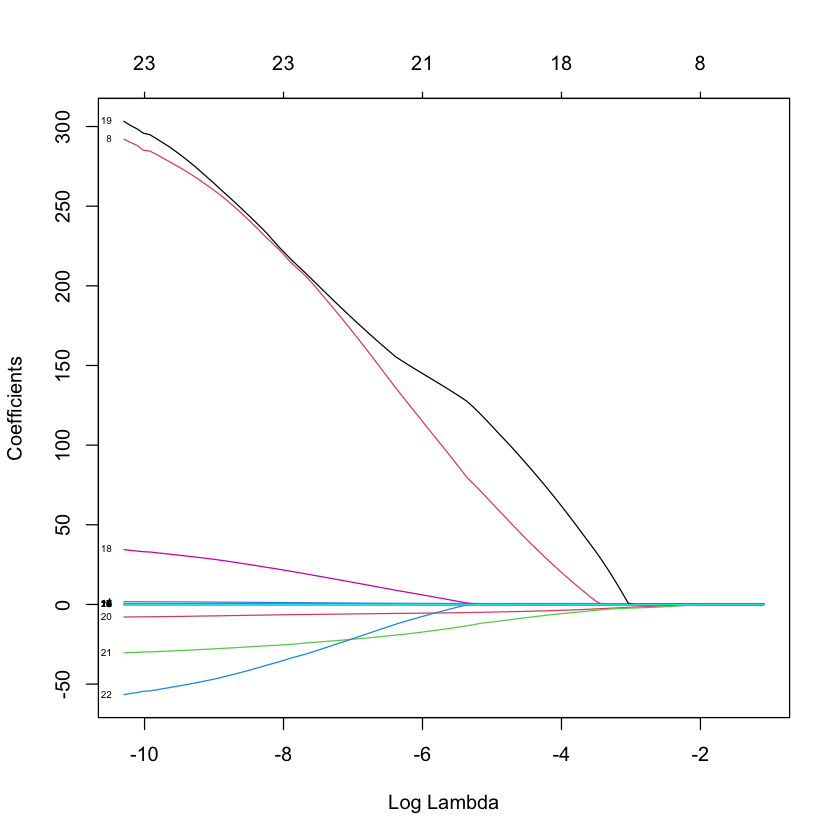

24 x 1 sparse Matrix of class "dgCMatrix"
                                                              s0
(Intercept)                                        -1.960886e+00
IT01V_packetsRecieved_ellen                         .           
IT01V_packetsLost_ellen                             .           
IT01V_frameWidth_ellen                              2.547197e-04
IT01V_totalFreezesDuration_ellen                    .           
IT01V_framesPerSecond_ellen                         1.904645e-02
IT01V_bytesReceived_in_bits_s_ellen                 .           
IT01V_totalProcessingDelay_ellen                    .           
IT01V_jitter_ellen                                  .           
IT01V_jitterBufferDelay_emissions_ellen             .           
IT01A_bytesReceived_in_bits_s_ellen                 .           
IT01A_jitterBufferDelay_emissions_ellen             .           
OT01V_packetsSent_s_ellen                           2.217127e-03
OT01V_bytesSent_in_bits_s_ellen                 

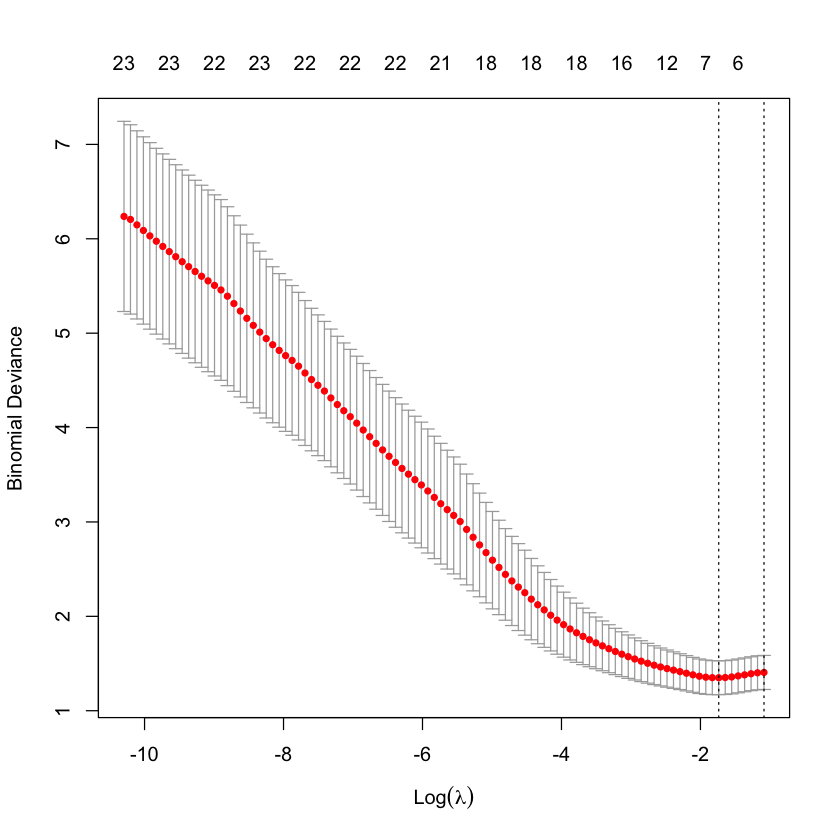

In [57]:
# alpha = 0.5(elastic net)
par(bg= "white")
model_manual <- glmnet(x_train, y_train, family = "binomial", alpha = 0.5)

# Plot the coefficient paths
plot(model_manual, xvar = "lambda", label = TRUE)

# Perform cross-validation to find the optimal lambda
cv_model_manual <- cv.glmnet(x_train, y_train, family = "binomial", alpha = 0.5)

# Plot the cross-validation curve
plot(cv_model_manual)

# Get the best lambda
best_lambda <- cv_model_manual$lambda.min

# Fit the final model with the best lambda
final_model_manual <- glmnet(x_train, y_train, family = "binomial", alpha = 0.5, lambda = best_lambda)

# Print the coefficients
coef(final_model_manual)

### Summary of output

In [58]:
#isolate only the vars it selected
selected_vars <- rownames(coef(final_model_manual))[-1][coef(final_model_manual)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("serviceable_agg ~", paste(selected_vars, collapse = " + ")))

# Fit a standard logistic regression model
logistic_model <- glm(formula, data = train_data, family = "binomial")
summary(logistic_model)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = formula, family = "binomial", data = train_data)

Coefficients:
                                                     Estimate Std. Error
(Intercept)                                        -6.007e+00  3.258e+00
IT01V_frameWidth_ellen                              1.768e-03  1.726e-03
IT01V_framesPerSecond_ellen                         5.354e-02  6.935e-02
OT01V_packetsSent_s_ellen                           1.607e-01  2.394e-01
OT01V_bytesSent_in_bits_s_ellen                    -1.756e-05  2.557e-05
OT01V_framesPerSecond_ellen                         2.125e-02  9.320e-02
OT01V_totalPacketSendDelay_ellen                    3.044e-03  1.310e-02
OT01V_totalPacketSendDelay_packetsSent_in_ms_ellen -6.570e-02  6.929e-02
                                                   z value Pr(>|z|)  
(Intercept)                                         -1.843   0.0653 .
IT01V_frameWidth_ellen                               1.024   0.3057  
IT01V_framesPerSecond_ellen                     

# Approach 2: Using cross-validation to find the optimal alpha

Function to perform cross validation

In [92]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, family = "binomial", alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)
}

Best alpha: 0.9 
[1] 0.03281764


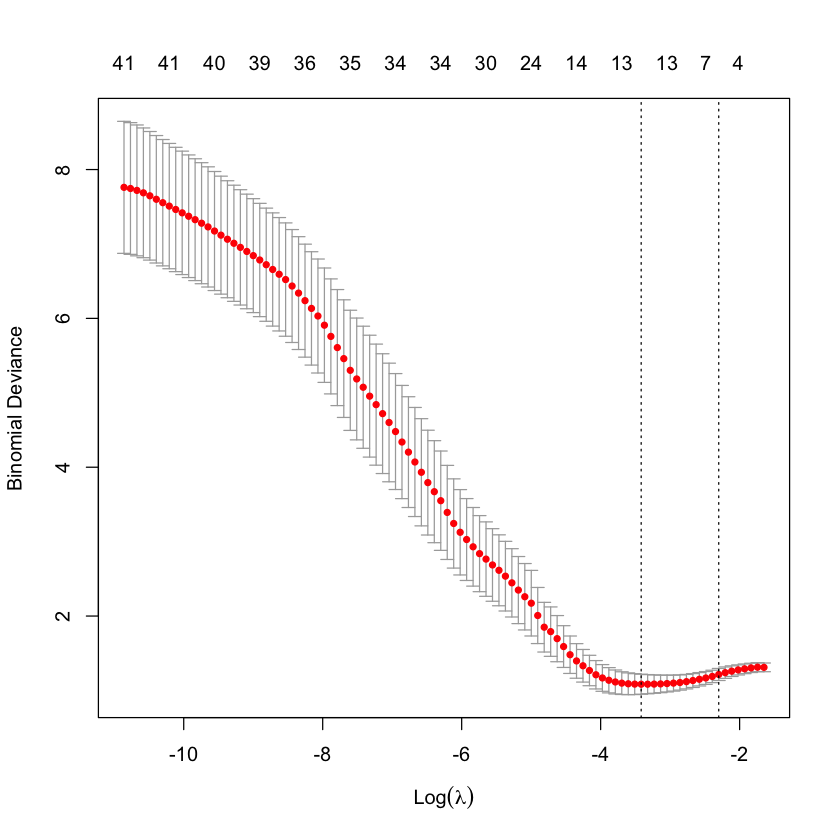

In [93]:
# Find the best alpha
best_alpha <- cv_alpha(x_train, y_train)
cat("Best alpha:", best_alpha, "\n")

# Fit the model with the best alpha
cv_model_best <- cv.glmnet(x_train, y_train, family = "binomial", alpha = best_alpha)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x_train, y_train, family = "binomial", alpha = best_alpha, lambda = best_lambda)


In [94]:
#isolate only the vars it selected
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("serviceable_agg ~", paste(selected_vars, collapse = " + ")))

# Fit a standard logistic regression model
logistic_model <- glm(formula, data = train_data, family = "binomial")
# Get the summary of the model, which includes p-values
summary_output <- summary(logistic_model)

# Extract coefficients and p-values
coef_summary <- data.frame(
  Estimate = summary_output$coefficients[, "Estimate"],
  `Std. Error` = summary_output$coefficients[, "Std. Error"],
  `z value` = summary_output$coefficients[, "z value"],
  `Pr(>|z|)` = summary_output$coefficients[, "Pr(>|z|)"]
)

# Display the results
print(coef_summary)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


                                                        Estimate   Std..Error
(Intercept)                                        -2.887978e+02 278.20704881
IT01V_packetsLost_ellen                            -2.706316e-01   0.45339719
IT01V_packetsLost_aadya                             3.649814e-01   0.27499856
IT01V_framesPerSecond_ellen                         6.771687e-01   0.99634901
IT01V_totalProcessingDelay_aadya                   -1.048101e-01   0.06751735
IT01V_jitterBufferDelay_emissions_aadya             1.080289e-02   0.02019076
OT01V_frameWidth_aadya                              2.053691e-01   0.21075817
OT01V_framesPerSecond_ellen                         5.296718e-02   0.11720680
OT01V_framesPerSecond_aadya                         2.735344e-01   0.83023052
OT01V_totalPacketSendDelay_packetsSent_in_ms_ellen -8.965363e-03   0.03453853
RIV_roundTripTime_aadya                            -1.255268e+01  23.65397012
RIA_fractionLost_ellen                              1.974899e+00

predictions

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.8055556 


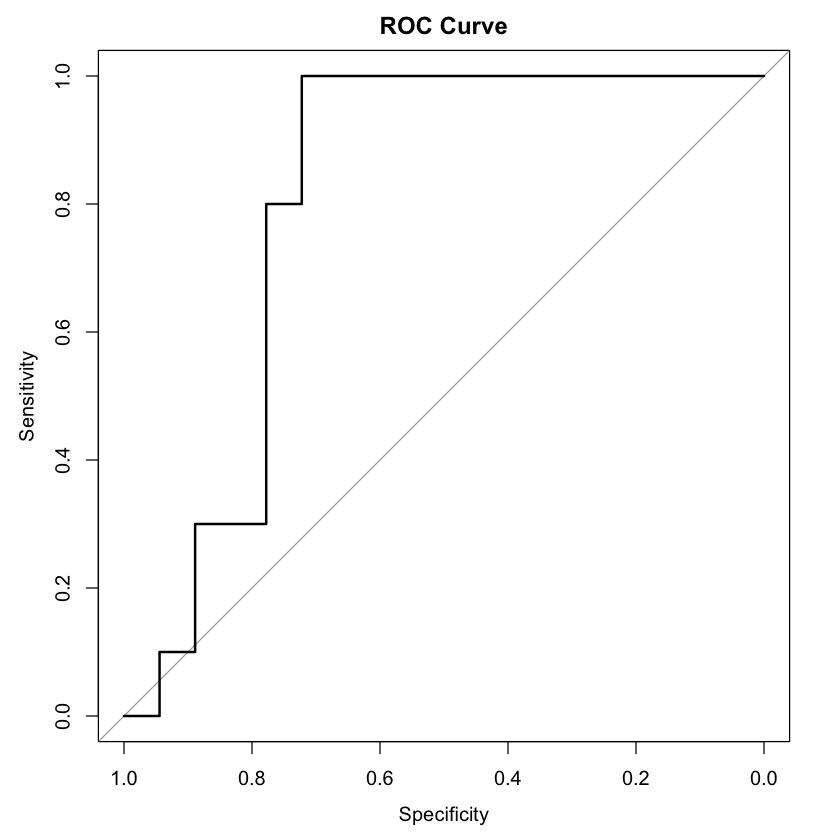

In [95]:
par(bg= "white")
# Make predictions on the test set
predictions <- predict(final_model_best, newx = x_test, type = "response", data = trim_data)
predictions_vector <- predictions[, 1]
# Evaluate the model
library(pROC)
roc_curve <- roc(y_test, predictions_vector)
auc_value <- auc(roc_curve)
cat("AUC:", auc_value, "\n")

# Plot ROC curve
plot(roc_curve, main = "ROC Curve")

In [96]:
# Convert probabilities into binary class predictions (threshold = 0.5)
threshold <- 0.5
predicted_classes <- ifelse(predictions_vector > threshold, 1, 0)

# Create a confusion matrix
library(caret)
predicted_classes <- factor(predicted_classes)
y_test <- factor(y_test)

# Ensure levels match for confusion matrix
predicted_classes <- factor(predicted_classes, levels = levels(y_test))

# Confusion Matrix
conf_matrix <- confusionMatrix(predicted_classes, y_test)
print(conf_matrix)


Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 14  5
         1  4  5
                                          
               Accuracy : 0.6786          
                 95% CI : (0.4765, 0.8412)
    No Information Rate : 0.6429          
    P-Value [Acc > NIR] : 0.4293          
                                          
                  Kappa : 0.2841          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.7778          
            Specificity : 0.5000          
         Pos Pred Value : 0.7368          
         Neg Pred Value : 0.5556          
             Prevalence : 0.6429          
         Detection Rate : 0.5000          
   Detection Prevalence : 0.6786          
      Balanced Accuracy : 0.6389          
                                          
       'Positive' Class : 0               
                                    